In [ ]:

!pip install torch torchvision pycocotools numpy pillow matplotlib pandas albumentations
!pip install git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Drive
drive.mount('/content/drive')

# Define paths
zip_path = "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip"
extract_path = "/content/dataset"

# Unzip if not already extracted
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted!")
else:
    print("Dataset already extracted.")


Mounted at /content/drive
Dataset extracted!


In [ ]:
import os
import cv2
import numpy as np
import json
from glob import glob
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import Instances
from google.colab.patches import cv2_imshow
from scipy.ndimage import label
import matplotlib.pyplot as plt
import pandas as pd
from pycocotools.coco import COCO
import albumentations as A
from google.colab import drive
import pycocotools.mask as mask_utils


In [ ]:
# Paths
TRAIN_IMAGE_DIR = '/content/dataset/train-300/data'
TRAIN_ANNOTATIONS = '/content/dataset/train-300/labels.json'
VAL_IMAGE_DIR = '/content/dataset/validation-300/data'
VAL_ANNOTATIONS = '/content/dataset/validation-300/labels.json'
TEST_IMAGE_DIR = '/content/dataset/test-30'
TRAINING_OUTPUT_DIR = '/content/drive/MyDrive/deeplabv3_training_output'
TEST_OUTPUT_DIR = '/content/drive/MyDrive/deeplabv3_test_output'
MODEL_SAVE_PATH = '/content/drive/MyDrive/deeplabv3_training_output/deeplabv3_model.pth'
TRAIN_FILTERED_ANNOTATIONS = '/content/dataset/train-300/labels_filtered.json'
VAL_FILTERED_ANNOTATIONS = '/content/dataset/validation-300/labels_filtered.json'


In [ ]:

category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)

print(categories)

names_cats = [cats["name"] for cats in categories]
print(len(names_cats), "COCO categories:", " ".join(names_cats))

names_scats = set([cats["supercategory"] for cats in categories])
print(len(names_scats), "COCO supercategories:", " ".join(names_scats))

In [ ]:
# Create output directories
os.makedirs(TRAINING_OUTPUT_DIR, exist_ok=True)
os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)

# Class mapping
target_category_ids = [15, 16, 25, 41]
category_mapping = {
    14: ('cake', 1),
    15: ('car', 2),
    25: ('dog', 3),
    41: ('person', 4)
}
class_names = ['background'] + [category_mapping[cid][0] for cid in sorted(category_mapping.keys())]
num_classes = len(class_names)  # 5 (background + 4 classes)


i

In [ ]:
# Debug: Check directories and files
def check_paths():
    for path in [TRAIN_IMAGE_DIR, VAL_IMAGE_DIR, TEST_IMAGE_DIR, TRAIN_ANNOTATIONS, VAL_ANNOTATIONS]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path not found: {path}")
    train_files = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*'))
    val_files = glob(os.path.join(VAL_IMAGE_DIR, '*.*'))
    test_files = glob(os.path.join(TEST_IMAGE_DIR, '*.*'))
    print(f"Train images ({len(train_files)}):", [os.path.basename(f) for f in train_files[:5]])
    print(f"Validation images ({len(val_files)}):", [os.path.basename(f) for f in val_files[:5]])
    print(f"Test images ({len(test_files)}):", [os.path.basename(f) for f in test_files[:5]])
    return train_files, val_files, test_files

train_files, val_files, test_files = check_paths()


Train images (300): ['000000001536.jpg', '000000000650.jpg', '000000002754.jpg', '000000012861.jpg', '000000013290.jpg']
Validation images (300): ['000000124798.jpg', '000000135604.jpg', '000000017207.jpg', '000000232538.jpg', '000000047112.jpg']
Test images (30): ['000000001594.jpg', '000000001653.jpg', '000000001550.jpg', '000000001410.jpg', '000000001551.jpg']


In [ ]:
# Debug: Validate original annotations
def validate_original_annotations(path, image_dir):
    with open(path) as f:
        data = json.load(f)
    ann_cats = set(ann.get('category_id', -1) for ann in data['annotations'])
    target_set = set(target_category_ids)
    missing_cats = target_set - ann_cats
    print(f"Categories in {path}: {sorted(ann_cats)}")
    if missing_cats:
        print(f"Warning: Missing target categories {missing_cats}. Dataset may lack annotations for these classes.")

    image_files = {os.path.basename(f).lower() for f in glob(os.path.join(image_dir, '*.*'))}
    ann_images = {os.path.basename(img.get('file_name', '')).lower() for img in data['images']}
    missing_images = ann_images - image_files
    extra_images = image_files - ann_images
    print(f"Images in directory: {len(image_files)}")
    print(f"Images in annotations: {len(ann_images)}")
    if missing_images:
        print(f"Missing images in directory: {len(missing_images)}, e.g., {list(missing_images)[:5]}")
        print("Suggestion: Ensure image filenames in labels.json match files in directory (case-sensitive).")
    if extra_images:
        print(f"Extra images in directory not in annotations: {len(extra_images)}, e.g., {list(extra_images)[:5]}")
    return data

validate_original_annotations(TRAIN_ANNOTATIONS, TRAIN_IMAGE_DIR)
validate_original_annotations(VAL_ANNOTATIONS, VAL_IMAGE_DIR)


Categories in /content/dataset/train-300/labels.json: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
Images in directory: 300
Images in annotations: 300
Categories in /content/dataset/validation-300/labels.json: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
Images in directory: 300
Images in annotations: 300


{'info': {'year': 2017,
  'version': '1.0',
  'contributor': 'COCO Consortium',
  'url': 'http://cocodataset.org',
  'date_created': '2017/09/01'},
 'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
   'id': 2,
   'name': 'Attribution-NonCommercial License'},
  {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
   'id': 3,
   'name': 'Attribution-NonCommercial-NoDerivs License'},
  {'url': 'http://creativecommons.org/licenses/by/2.0/',
   'id': 4,
   'name': 'Attribution License'},
  {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
   'id': 5,
   'name': 'Attribution-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
   'id': 6,
   'name': 'Attribution-NoDerivs License'},
  {'url': 'http://flickr.com/commons/usage/',
   'id': 7,
   'name': 'No known copyright restrictions'},
  {'url'

In [ ]:
# Step 1: Filter annotations
def filter_annotations(input_path, output_path, target_ids, image_dir):
    with open(input_path) as f:
        data = json.load(f)

    filtered_categories = [
        {'id': category_mapping[cat_id][1], 'name': category_mapping[cat_id][0], 'supercategory': 'object'}
        for cat_id in target_ids
    ]

    available_images = {os.path.basename(f).lower(): f for f in glob(os.path.join(image_dir, '*.*'))}
    print(f"Available images in {image_dir}: {len(available_images)}")

    filtered_images = []
    filtered_annotations = []
    image_id_map = {}
    new_image_id = 0
    invalid_anns = 0
    skipped_images = 0

    for img in data['images']:
        if not img.get('file_name'):
            print(f"Skipping image with missing file_name: {img}")
            skipped_images += 1
            continue
        file_name = os.path.basename(img['file_name']).lower()
        if file_name in available_images:
            img['file_name'] = available_images[file_name]
            image_id_map[img['id']] = new_image_id
            img['id'] = new_image_id
            filtered_images.append(img)
            new_image_id += 1
        else:
            print(f"Skipping image, not found in directory: {file_name}")
            skipped_images += 1

    for ann in data['annotations']:
        if not all(key in ann for key in ['image_id', 'category_id', 'segmentation', 'bbox']):
            print(f"Skipping invalid annotation: {ann}")
            invalid_anns += 1
            continue
        if ann['category_id'] in target_ids and ann['image_id'] in image_id_map:
            ann['image_id'] = image_id_map[ann['image_id']]
            ann['category_id'] = category_mapping[ann['category_id']][1]
            filtered_annotations.append(ann)

    if skipped_images:
        print(f"Skipped {skipped_images} images due to missing files or invalid entries.")
        print("Suggestion: Check that image paths in labels.json match files in directory.")
    if invalid_anns:
        print(f"Skipped {invalid_anns} invalid annotations.")
    if not filtered_images:
        raise ValueError(f"No valid images found in {image_dir} matching annotations in {input_path}. Check image paths and directory contents.")

    filtered_data = {
        'info': data.get('info', {'description': 'Filtered COCO Dataset for DeepLabV3'}),
        'licenses': data.get('licenses', [{'id': 1, 'name': 'Unknown', 'url': ''}]),
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': filtered_categories
    }

    with open(output_path, 'w') as f:
        json.dump(filtered_data, f)
    print(f"Saved filtered annotations to {output_path}")
    print(f"Filtered images: {len(filtered_images)}, annotations: {len(filtered_annotations)}")
    return filtered_data

filter_annotations(TRAIN_ANNOTATIONS, TRAIN_FILTERED_ANNOTATIONS, target_category_ids, TRAIN_IMAGE_DIR)
filter_annotations(VAL_ANNOTATIONS, VAL_FILTERED_ANNOTATIONS, target_category_ids, VAL_IMAGE_DIR)


Available images in /content/dataset/train-300/data: 300
Saved filtered annotations to /content/dataset/train-300/labels_filtered.json
Filtered images: 300, annotations: 1468
Available images in /content/dataset/validation-300/data: 300
Saved filtered annotations to /content/dataset/validation-300/labels_filtered.json
Filtered images: 300, annotations: 2072


{'info': {'year': 2017,
  'version': '1.0',
  'contributor': 'COCO Consortium',
  'url': 'http://cocodataset.org',
  'date_created': '2017/09/01'},
 'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
   'id': 1,
   'name': 'Attribution-NonCommercial-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
   'id': 2,
   'name': 'Attribution-NonCommercial License'},
  {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
   'id': 3,
   'name': 'Attribution-NonCommercial-NoDerivs License'},
  {'url': 'http://creativecommons.org/licenses/by/2.0/',
   'id': 4,
   'name': 'Attribution License'},
  {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
   'id': 5,
   'name': 'Attribution-ShareAlike License'},
  {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
   'id': 6,
   'name': 'Attribution-NoDerivs License'},
  {'url': 'http://flickr.com/commons/usage/',
   'id': 7,
   'name': 'No known copyright restrictions'},
  {'url'

In [ ]:
# Custom Dataset
class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(ann_file)
        self.transform = transform
        self.cat_ids = [category_mapping[cid][1] for cid in target_category_ids]
        self.img_ids = self.coco.getImgIds()
        if not self.img_ids:
            raise ValueError(f"No images found in {ann_file}. Check dataset and annotations.")
        print(f"Dataset {ann_file}: {len(self.img_ids)} images for categories {self.cat_ids}")
        self.cat_id_map = {category_mapping[cid][1]: i + 1 for i, cid in enumerate(target_category_ids)}
        self.cat_id_map[0] = 0  # Background

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = img_info['file_name']
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            if ann['category_id'] in self.cat_id_map:
                ann_mask = self.coco.annToMask(ann)
                mask[ann_mask > 0] = self.cat_id_map[ann['category_id']]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        return {
            'image': torch.as_tensor(image.transpose(2, 0, 1), dtype=torch.float32),
            'mask': torch.as_tensor(mask, dtype=torch.long)
        }


In [ ]:
# Data Augmentation
training_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
import seaborn as sns

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<ipython-input-21-1980691837>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')


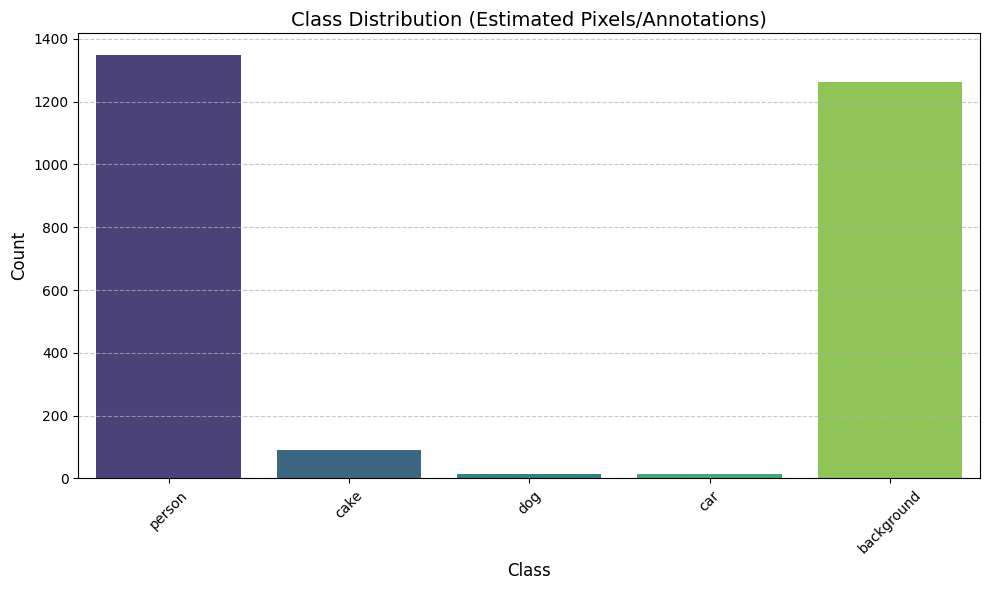

Class weights: [1.1620537042617798, 16.131868362426758, 112.92308044433594, 104.85713958740234, 1.0874073505401611]


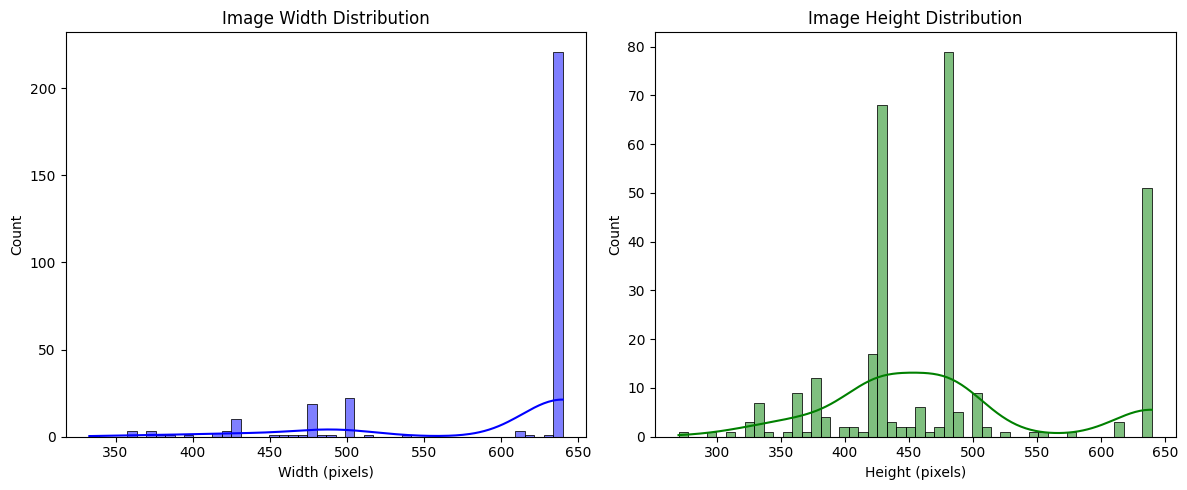

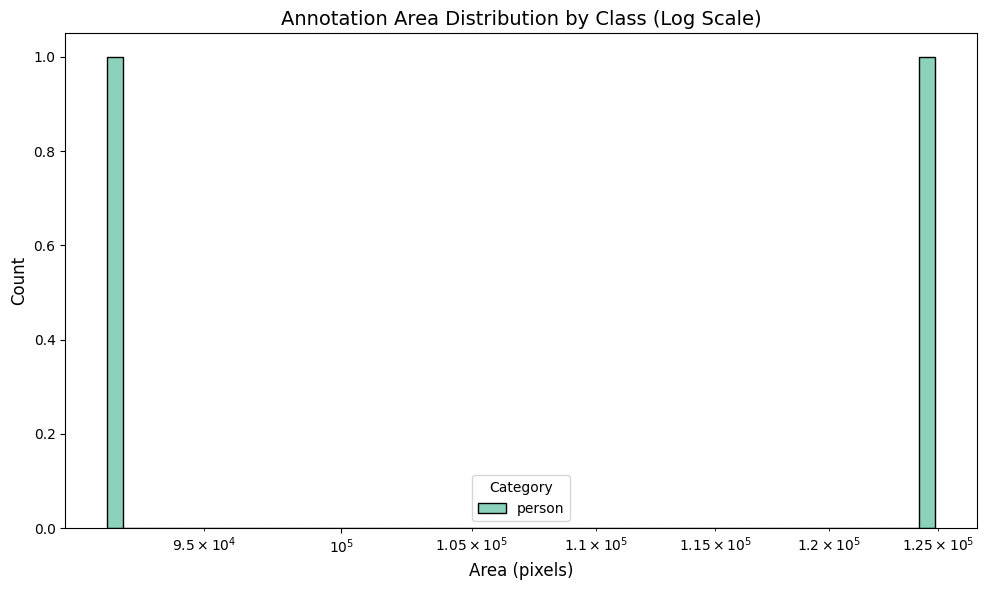

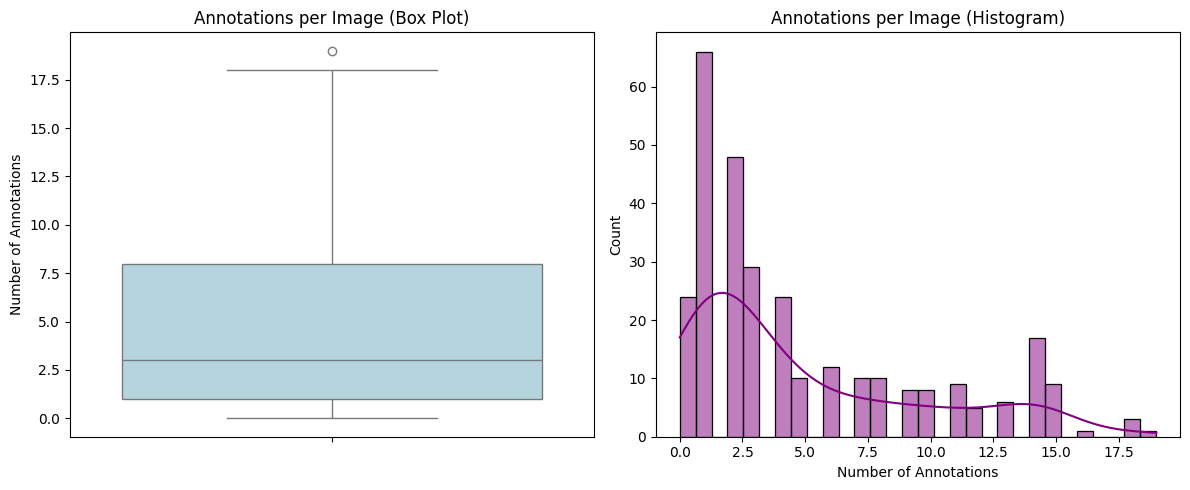

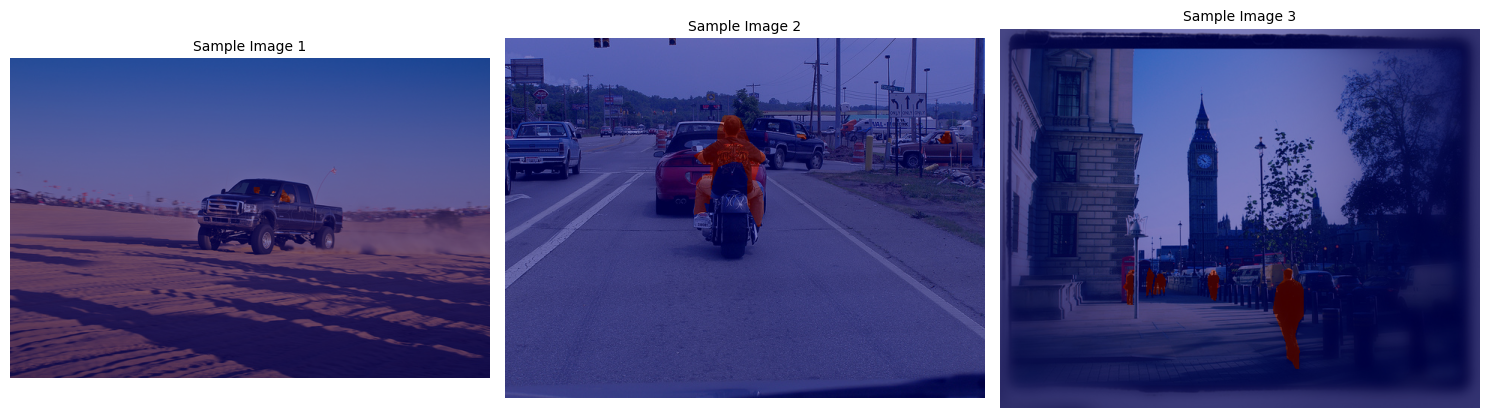

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
def perform_eda(coco, output_dir):
    img_ids = coco.getImgIds()
    imgs = coco.loadImgs(img_ids)
    cat_ids = [category_mapping[cid][1] for cid in target_category_ids]

    # Class Distribution
    ann_ids = coco.getAnnIds(imgIds=img_ids, catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)
    filtered_df = pd.DataFrame(anns)
    if not filtered_df.empty:
        filtered_df['category_name'] = filtered_df['category_id'].map({category_mapping[cid][1]: category_mapping[cid][0] for cid in target_category_ids})
        background_pixels = 0
        total_pixels = 0
        for img_id in img_ids[:10]:
            img_info = coco.loadImgs(img_id)[0]
            ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
            anns = coco.loadAnns(ann_ids)
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
            for ann in anns:
                ann_mask = coco.annToMask(ann)
                mask[ann_mask > 0] = ann['category_id']
            background_pixels += (mask == 0).sum()
            total_pixels += mask.size
        background_ratio = background_pixels / total_pixels if total_pixels else 1.0

        class_counts = filtered_df['category_name'].value_counts().to_dict()
        class_counts['background'] = background_ratio * sum(class_counts.values())

        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
        plt.title('Class Distribution (Estimated Pixels/Annotations)', fontsize=14)
        plt.xlabel('Class', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'class_distribution.png'))
        plt.show()

        counts = filtered_df['category_name'].value_counts()
        total = counts.sum()
        weights = {cat: total / count for cat, count in counts.items()}
        weights['background'] = total / (background_ratio * total) if background_ratio else 1.0
        class_weights = torch.tensor([weights.get('background', 1.0)] + [weights.get(cat, 1.0) for cat in [category_mapping[cid][0] for cid in target_category_ids]], dtype=torch.float32)
        print("Class weights:", class_weights.tolist())
    else:
        print("No annotations found. Using uniform class weights.")
        class_weights = torch.ones(num_classes, dtype=torch.float32)

    # Image Size Distribution
    widths = [img['width'] for img in imgs]
    heights = [img['height'] for img in imgs]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, bins=50, kde=True, color='blue')
    plt.title('Image Width Distribution', fontsize=12)
    plt.xlabel('Width (pixels)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.subplot(1, 2, 2)
    sns.histplot(heights, bins=50, kde=True, color='green')
    plt.title('Image Height Distribution', fontsize=12)
    plt.xlabel('Height (pixels)', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'image_size_distribution.png'))
    plt.show()

    # Annotation Area Distribution (Class-wise)
    if anns:
        areas = []
        categories = []
        for ann in anns:
            if not ann.get('iscrowd', False):
                areas.append(ann['area'])
                cat_name = category_mapping[next(cid for cid in target_category_ids if category_mapping[cid][1] == ann['category_id'])][0]
                categories.append(cat_name)
        area_df = pd.DataFrame({'Area': areas, 'Category': categories})

        plt.figure(figsize=(10, 6))
        sns.histplot(data=area_df, x='Area', hue='Category', bins=50, log_scale=True, palette='Set2', multiple='stack')
        plt.title('Annotation Area Distribution by Class (Log Scale)', fontsize=14)
        plt.xlabel('Area (pixels)', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'annotation_area_distribution.png'))
        plt.show()

    # Annotations per Image
    ann_counts = [len(coco.getAnnIds(imgIds=img_id, catIds=cat_ids)) for img_id in img_ids]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=ann_counts, color='lightblue')
    plt.title('Annotations per Image (Box Plot)', fontsize=12)
    plt.ylabel('Number of Annotations', fontsize=10)
    plt.subplot(1, 2, 2)
    sns.histplot(ann_counts, bins=30, kde=True, color='purple')
    plt.title('Annotations per Image (Histogram)', fontsize=12)
    plt.xlabel('Number of Annotations', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'annotations_per_image.png'))
    plt.show()

    # Sample Visualizations
    if img_ids:
        sample_ids = random.sample(img_ids, min(3, len(img_ids)))
        plt.figure(figsize=(15, 5))
        for i, img_id in enumerate(sample_ids):
            img_info = coco.loadImgs(img_id)[0]
            img_path = img_info['file_name']
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
            anns = coco.loadAnns(ann_ids)
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
            for ann in anns:
                ann_mask = coco.annToMask(ann)
                mask[ann_mask > 0] = ann['category_id']

            plt.subplot(1, 3, i+1)
            plt.imshow(image)
            plt.imshow(mask, alpha=0.5, cmap='jet')
            plt.title(f"Sample Image {i+1}", fontsize=10)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'sample_visualizations.png'))
        plt.show()

    return class_weights

coco_train = COCO(TRAIN_FILTERED_ANNOTATIONS)
class_weights = perform_eda(coco_train, TRAINING_OUTPUT_DIR)

In [ ]:
# Data Loaders
training_dataset = COCOSegmentationDataset(TRAIN_IMAGE_DIR, TRAIN_FILTERED_ANNOTATIONS, training_transform)
validation_dataset = COCOSegmentationDataset(VAL_IMAGE_DIR, VAL_FILTERED_ANNOTATIONS, validation_transform)
training_loader = DataLoader(training_dataset, batch_size=8, shuffle=True, num_workers=1)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=1)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Dataset /content/dataset/train-300/labels_filtered.json: 300 images for categories [1, 2, 3, 4]
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Dataset /content/dataset/validation-300/labels_filtered.json: 300 images for categories [1, 2, 3, 4]


In [ ]:
# Step 3: Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


i

In [ ]:
#Step 4: Training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Saved model to {MODEL_SAVE_PATH}")

train_model(model, training_loader, validation_loader, criterion, optimizer, num_epochs=20)


Epoch 1/20, Train Loss: 0.3082, Val Loss: 2.1330
Epoch 2/20, Train Loss: 0.2388, Val Loss: 2.2670
Epoch 3/20, Train Loss: 0.1937, Val Loss: 2.3915
Epoch 4/20, Train Loss: 0.1950, Val Loss: 2.6369
Epoch 5/20, Train Loss: 0.1969, Val Loss: 2.7053
Epoch 6/20, Train Loss: 0.2506, Val Loss: 2.5621
Epoch 7/20, Train Loss: 0.2395, Val Loss: 2.9425
Epoch 8/20, Train Loss: 0.2062, Val Loss: 3.0754
Epoch 9/20, Train Loss: 0.1802, Val Loss: 3.1048
Epoch 10/20, Train Loss: 0.1384, Val Loss: 3.1552


In [ ]:
def compute_metrics(outputs, masks, num_classes):
    outputs = torch.argmax(outputs, dim=1)
    confusion_matrix = np.zeros((num_classes, num_classes))
    for pred, gt in zip(outputs.cpu().numpy().flatten(), masks.cpu().numpy().flatten()):
        confusion_matrix[gt, pred] += 1

    iou = []
    for i in range(num_classes):
        intersection = confusion_matrix[i, i]
        union = confusion_matrix[i].sum() + confusion_matrix[:, i].sum() - intersection
        iou.append(intersection / union if union > 0 else 0.0)

    miou = np.mean(iou)
    pixel_acc = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
    return miou, pixel_acc

In [ ]:
def evaluate_model(model, val_loader, num_classes):
    model.eval()
    total_miou = 0.0
    total_pixel_acc = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)['out']
            miou, pixel_acc = compute_metrics(outputs, masks, num_classes)
            total_miou += miou
            total_pixel_acc += pixel_acc
            num_batches += 1

    avg_miou = total_miou / num_batches
    avg_pixel_acc = total_pixel_acc / num_batches
    results = {'mIoU': avg_miou, 'Pixel Accuracy': avg_pixel_acc}

    metrics_path = os.path.join(TRAINING_OUTPUT_DIR, 'validation_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(results, f)
    print(f"Saved evaluation results to {metrics_path}")
    return results

print("\n--- Evaluating Validation Set ---")
eval_results = evaluate_model(model, validation_loader, num_classes)
print(f"Validation mIoU: {eval_results['mIoU']:.4f}, Pixel Accuracy: {eval_results['Pixel Accuracy']:.4f}")



--- Evaluating Validation Set ---
Saved evaluation results to /content/drive/MyDrive/deeplabv3_training_output/validation_metrics.json
Validation mIoU: 0.3081, Pixel Accuracy: 0.8817


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, val_loader, num_classes, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(masks.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Flattened for Segmentation)")
    plt.show()


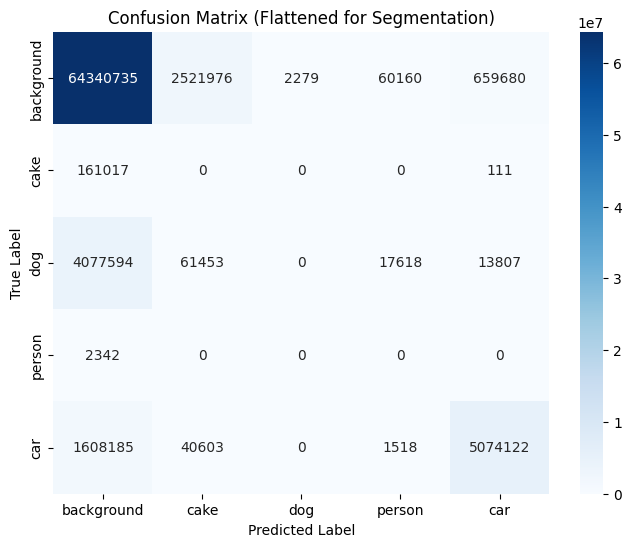

In [ ]:
class_names = ['background', 'cake', 'dog', 'person', 'car']  # use actual mapping
plot_confusion_matrix(model, validation_loader, num_classes, class_names)


--- Performing Inference on Test Images from: /content/dataset/test-30 ---

Processing test image 1/3: 000000001654.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001654_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001654_instance.png


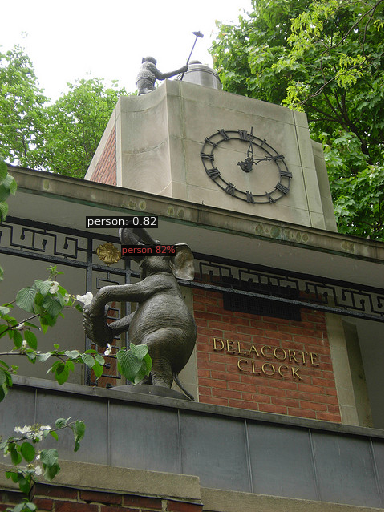

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001654.png

Processing test image 2/3: 000000001371.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001371_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001371_instance.png


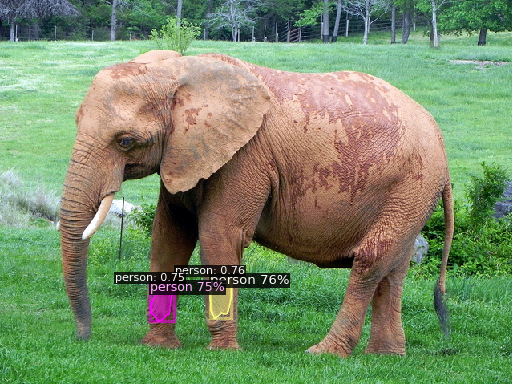

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001371.png

Processing test image 3/3: 000000001380.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001380_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001380_instance.png


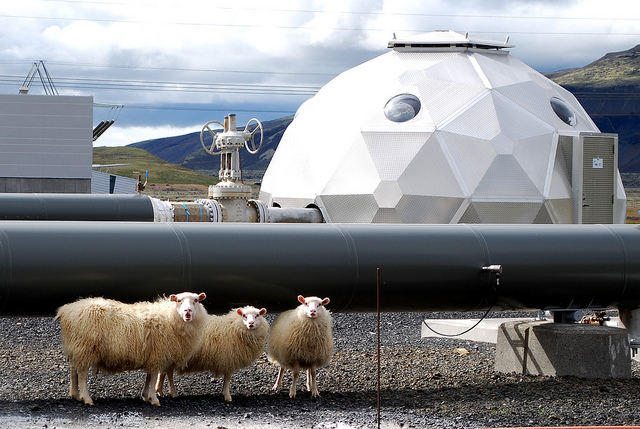

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001380.png

Saved 3 predictions to /content/drive/MyDrive/deeplabv3_test_output/panoptic_results.json

Inference on test images complete.

Pipeline complete.


In [ ]:
# Step 6: Test Inference
model.eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if not os.path.exists(TEST_IMAGE_DIR):
    print(f"Test image directory not found at {TEST_IMAGE_DIR}.")
else:
    print(f"\n--- Performing Inference on Test Images from: {TEST_IMAGE_DIR} ---")
    test_image_paths = [f for f in glob(os.path.join(TEST_IMAGE_DIR, '*.*')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(test_image_paths)
    num_test_visualizations = min(3, len(test_image_paths))

    if num_test_visualizations == 0:
        print("No image files found in the test directory.")
    else:
        dataset_metadata = MetadataCatalog.get("my_coco_train_custom")
        dataset_metadata.thing_classes = class_names
        predictions = []
        confidence_threshold = 0.7

        for i in range(num_test_visualizations):
            img_path = test_image_paths[i]
            im = cv2.imread(img_path)
            if im is None:
                print(f"Could not read image: {img_path}. Skipping.")
                continue

            print(f"\nProcessing test image {i+1}/{num_test_visualizations}: {os.path.basename(img_path)}")
            input_image = Image.open(img_path).convert('RGB')
            input_tensor = preprocess(input_image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)['out'][0]
            output = torch.softmax(output, dim=0).cpu().numpy()
            output = cv2.resize(output.transpose(1, 2, 0), (im.shape[1], im.shape[0]), interpolation=cv2.INTER_LINEAR)
            output = output.transpose(2, 0, 1)

            semantic_mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
            for idx, (class_name, mapped_id) in enumerate([(category_mapping[cid][0], category_mapping[cid][1]) for cid in target_category_ids], 1):
                class_mask = output[idx] > confidence_threshold
                semantic_mask[class_mask] = mapped_id

            instance_mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint32)
            instance_id = 1
            for idx, mapped_id in enumerate([category_mapping[cid][1] for cid in target_category_ids], 1):
                class_mask = (semantic_mask == mapped_id).astype(np.uint8)
                labeled_mask, num_instances = label(class_mask)
                for inst_id in range(1, num_instances + 1):
                    instance_mask[labeled_mask == inst_id] = instance_id
                    instance_id += 1

            semantic_output_path = os.path.join(TEST_OUTPUT_DIR, os.path.basename(img_path).rsplit('.', 1)[0] + '_semantic.png')
            Image.fromarray(semantic_mask).save(semantic_output_path)
            print(f"Saved semantic mask: {semantic_output_path}")

            instance_output_path = os.path.join(TEST_OUTPUT_DIR, os.path.basename(img_path).rsplit('.', 1)[0] + '_instance.png')
            Image.fromarray(instance_mask).save(instance_output_path)
            print(f"Saved instance mask: {instance_output_path}")

            pred_instances = Instances((im.shape[0], im.shape[1]))
            pred_masks = []
            pred_classes = []
            pred_scores = []
            pred_boxes = []

            for inst_id in range(1, instance_id):
                inst_mask = instance_mask == inst_id
                if inst_mask.sum() == 0:
                    continue
                class_id = semantic_mask[inst_mask][0]
                if class_id == 0:
                    continue
                idx = next(i for i, mapped_id in enumerate([category_mapping[cid][1] for cid in target_category_ids], 1) if mapped_id == class_id)
                y, x = np.where(inst_mask)
                box = [x.min(), y.min(), x.max(), y.max()]
                score = output[idx][inst_mask].mean()
                pred_masks.append(inst_mask)
                pred_classes.append(idx)
                pred_scores.append(score)
                pred_boxes.append(box)

            if pred_masks:
                pred_instances.pred_masks = torch.tensor(np.array(pred_masks), dtype=torch.bool)
                pred_instances.pred_classes = torch.tensor(pred_classes, dtype=torch.int64)
                pred_instances.scores = torch.tensor(pred_scores, dtype=torch.float32)
                pred_instances.pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)

            v = Visualizer(im[:, :, ::-1], metadata=dataset_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
            if len(pred_masks) > 0:
                out = v.draw_instance_predictions(pred_instances)
                for box, score, class_id in zip(pred_boxes, pred_scores, pred_classes):
                    class_name = class_names[class_id]
                    x0, y0, _, _ = box
                    v.draw_text(f"{class_name}: {score:.2f}", (x0, y0 - 10), font_size=10, color="white")
                visualized_img = out.get_image()[:, :, ::-1]
            else:
                visualized_img = im.copy()
            cv2_imshow(visualized_img)

            vis_output_path = os.path.join(TEST_OUTPUT_DIR, f'test_result_{os.path.basename(img_path).rsplit(".", 1)[0]}.png')
            cv2.imwrite(vis_output_path, visualized_img)
            print(f"Saved visualization: {vis_output_path}")

            # Convert pred_scores to native floats for JSON serialization
            scores_as_floats = [float(score) for score in pred_scores]

            predictions.append({
                'image': os.path.basename(img_path),
                'semantic_mask': semantic_mask.tolist(),
                'instance_mask': instance_mask.tolist(),
                'scores': scores_as_floats
            })

        json_output_path = os.path.join(TEST_OUTPUT_DIR, 'panoptic_results.json')
        with open(json_output_path, 'w') as f:
            json.dump(predictions, f)
        print(f"\nSaved {len(predictions)} predictions to {json_output_path}")

        print("\nInference on test images complete.")

print("\nPipeline complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train images (300): ['000000001536.jpg', '000000000650.jpg', '000000002754.jpg', '000000012861.jpg', '000000013290.jpg']
Validation images (300): ['000000124798.jpg', '000000135604.jpg', '000000017207.jpg', '000000232538.jpg', '000000047112.jpg']
Test images (30): ['000000001594.jpg', '000000001653.jpg', '000000001550.jpg', '000000001410.jpg', '000000001551.jpg']
Categories in /content/dataset/train-300/labels.json: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
Images in directory: 300
Images in annotations: 300
Categories in /content/dataset/validation-300/labels.json: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26

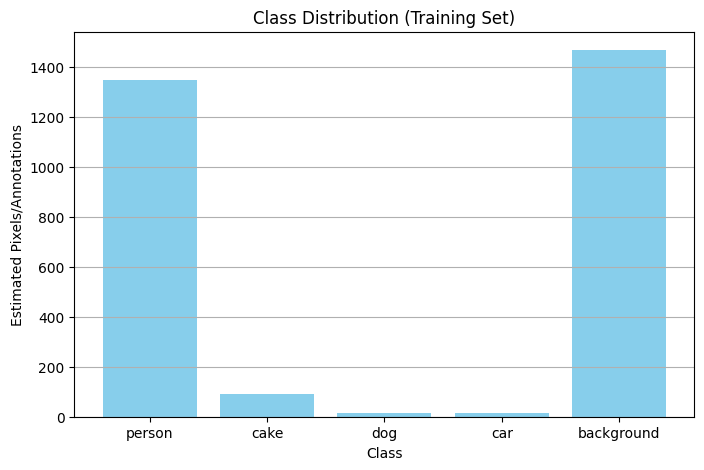

Class weights: [1.0, 16.131868362426758, 112.92308044433594, 104.85713958740234, 1.0874073505401611]


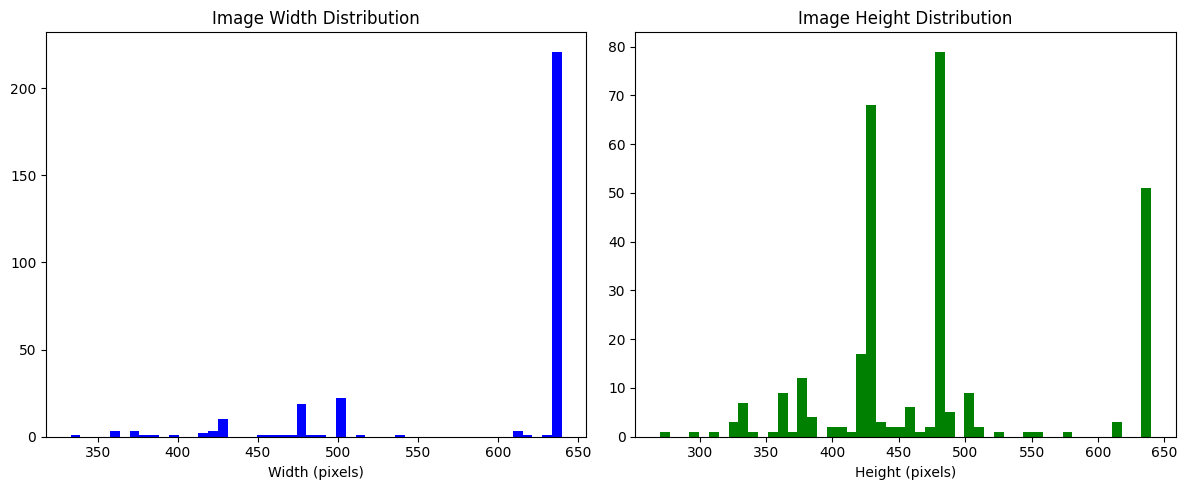

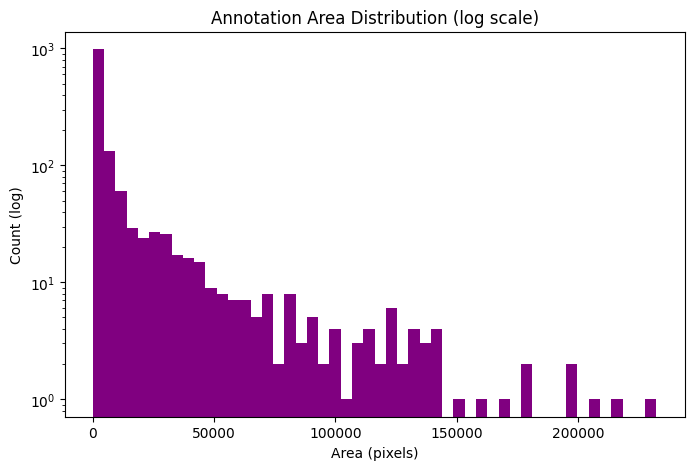

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Dataset /content/dataset/train-300/labels_filtered.json: 300 images for categories [1, 2, 3, 4]
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Dataset /content/dataset/validation-300/labels_filtered.json: 300 images for categories [1, 2, 3, 4]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 179MB/s]


Epoch 1/10, Train Loss: 1.1923, Val Loss: 1.8523
Epoch 2/10, Train Loss: 0.8115, Val Loss: 1.8582
Epoch 3/10, Train Loss: 0.6811, Val Loss: 1.9688
Epoch 4/10, Train Loss: 0.5270, Val Loss: 1.9709
Epoch 5/10, Train Loss: 0.4288, Val Loss: 2.1654
Epoch 6/10, Train Loss: 0.3273, Val Loss: 2.3111
Epoch 7/10, Train Loss: 0.2713, Val Loss: 2.5063
Epoch 8/10, Train Loss: 0.2350, Val Loss: 2.5108
Epoch 9/10, Train Loss: 0.2173, Val Loss: 2.2992
Epoch 10/10, Train Loss: 0.1995, Val Loss: 2.9938
Saved model to /content/drive/MyDrive/deeplabv3_training_output/deeplabv3_model.pth

--- Evaluating Validation Set ---
Saved evaluation results to /content/drive/MyDrive/deeplabv3_training_output/validation_metrics.json
Validation mIoU: 0.3130, Pixel Accuracy: 0.8745

--- Performing Inference on Test Images from: /content/dataset/test-30 ---

Processing test image 1/3: 000000001492.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001492_semantic.png
Saved instance mask: /conten

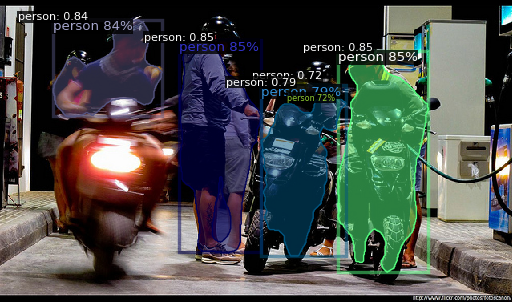

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001492.png

Processing test image 2/3: 000000001410.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001410_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001410_instance.png


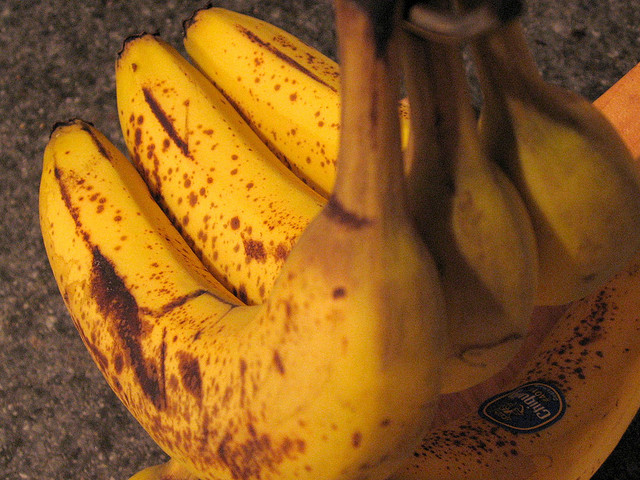

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001410.png

Processing test image 3/3: 000000001751.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001751_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001751_instance.png


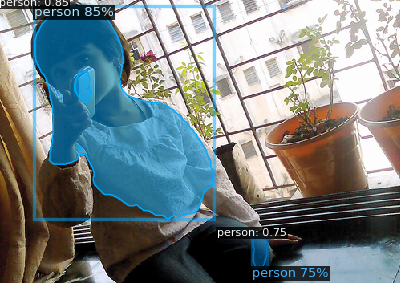

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001751.png


TypeError: Object of type float32 is not JSON serializable

In [ ]:
import os
import cv2
import numpy as np
import json
from glob import glob
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import Instances
from google.colab.patches import cv2_imshow
from scipy.ndimage import label
import matplotlib.pyplot as plt
import pandas as pd
from pycocotools.coco import COCO
import albumentations as A
from google.colab import drive
import pycocotools.mask as mask_utils

# Mount Google Drive
drive.mount('/content/drive')

# Paths
TRAIN_IMAGE_DIR = '/content/dataset/train-300/data'
TRAIN_ANNOTATIONS = '/content/dataset/train-300/labels.json'
VAL_IMAGE_DIR = '/content/dataset/validation-300/data'
VAL_ANNOTATIONS = '/content/dataset/validation-300/labels.json'
TEST_IMAGE_DIR = '/content/dataset/test-30'
TRAINING_OUTPUT_DIR = '/content/drive/MyDrive/deeplabv3_training_output'
TEST_OUTPUT_DIR = '/content/drive/MyDrive/deeplabv3_test_output'
MODEL_SAVE_PATH = '/content/drive/MyDrive/deeplabv3_training_output/deeplabv3_model.pth'
TRAIN_FILTERED_ANNOTATIONS = '/content/dataset/train-300/labels_filtered.json'
VAL_FILTERED_ANNOTATIONS = '/content/dataset/validation-300/labels_filtered.json'

# Create output directories
os.makedirs(TRAINING_OUTPUT_DIR, exist_ok=True)
os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)

# Class mapping
target_category_ids = [14, 15, 25, 41]
category_mapping = {
    14: ('cake', 1),
    15: ('car', 2),
    25: ('dog', 3),
    41: ('person', 4)
}
class_names = ['background'] + [category_mapping[cid][0] for cid in sorted(category_mapping.keys())]
num_classes = len(class_names)  # 5 (background + 4 classes)

# Debug: Check directories and files
def check_paths():
    for path in [TRAIN_IMAGE_DIR, VAL_IMAGE_DIR, TEST_IMAGE_DIR, TRAIN_ANNOTATIONS, VAL_ANNOTATIONS]:
        if not os.path.exists(path):
            raise FileNotFoundError(f"Path not found: {path}")
    train_files = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*'))
    val_files = glob(os.path.join(VAL_IMAGE_DIR, '*.*'))
    test_files = glob(os.path.join(TEST_IMAGE_DIR, '*.*'))
    print(f"Train images ({len(train_files)}):", [os.path.basename(f) for f in train_files[:5]])
    print(f"Validation images ({len(val_files)}):", [os.path.basename(f) for f in val_files[:5]])
    print(f"Test images ({len(test_files)}):", [os.path.basename(f) for f in test_files[:5]])
    return train_files, val_files, test_files

train_files, val_files, test_files = check_paths()

# Debug: Validate original annotations
def validate_original_annotations(path, image_dir):
    with open(path) as f:
        data = json.load(f)
    ann_cats = set(ann.get('category_id', -1) for ann in data['annotations'])
    target_set = set(target_category_ids)
    missing_cats = target_set - ann_cats
    print(f"Categories in {path}: {sorted(ann_cats)}")
    if missing_cats:
        print(f"Warning: Missing target categories {missing_cats}. Dataset may lack annotations for these classes.")

    image_files = {os.path.basename(f).lower() for f in glob(os.path.join(image_dir, '*.*'))}
    ann_images = {os.path.basename(img.get('file_name', '')).lower() for img in data['images']}
    missing_images = ann_images - image_files
    extra_images = image_files - ann_images
    print(f"Images in directory: {len(image_files)}")
    print(f"Images in annotations: {len(ann_images)}")
    if missing_images:
        print(f"Missing images in directory: {len(missing_images)}, e.g., {list(missing_images)[:5]}")
        print("Suggestion: Ensure image filenames in labels.json match files in directory (case-sensitive).")
    if extra_images:
        print(f"Extra images in directory not in annotations: {len(extra_images)}, e.g., {list(extra_images)[:5]}")
    return data

validate_original_annotations(TRAIN_ANNOTATIONS, TRAIN_IMAGE_DIR)
validate_original_annotations(VAL_ANNOTATIONS, VAL_IMAGE_DIR)

# Step 1: Filter annotations
def filter_annotations(input_path, output_path, target_ids, image_dir):
    with open(input_path) as f:
        data = json.load(f)

    filtered_categories = [
        {'id': category_mapping[cat_id][1], 'name': category_mapping[cat_id][0], 'supercategory': 'object'}
        for cat_id in target_ids
    ]

    available_images = {os.path.basename(f).lower(): f for f in glob(os.path.join(image_dir, '*.*'))}
    print(f"Available images in {image_dir}: {len(available_images)}")

    filtered_images = []
    filtered_annotations = []
    image_id_map = {}
    new_image_id = 0
    invalid_anns = 0
    skipped_images = 0

    for img in data['images']:
        if not img.get('file_name'):
            print(f"Skipping image with missing file_name: {img}")
            skipped_images += 1
            continue
        file_name = os.path.basename(img['file_name']).lower()
        if file_name in available_images:
            img['file_name'] = available_images[file_name]
            image_id_map[img['id']] = new_image_id
            img['id'] = new_image_id
            filtered_images.append(img)
            new_image_id += 1
        else:
            print(f"Skipping image, not found in directory: {file_name}")
            skipped_images += 1

    for ann in data['annotations']:
        if not all(key in ann for key in ['image_id', 'category_id', 'segmentation', 'bbox']):
            print(f"Skipping invalid annotation: {ann}")
            invalid_anns += 1
            continue
        if ann['category_id'] in target_ids and ann['image_id'] in image_id_map:
            ann['image_id'] = image_id_map[ann['image_id']]
            ann['category_id'] = category_mapping[ann['category_id']][1]
            filtered_annotations.append(ann)

    if skipped_images:
        print(f"Skipped {skipped_images} images due to missing files or invalid entries.")
        print("Suggestion: Check that image paths in labels.json match files in directory.")
    if invalid_anns:
        print(f"Skipped {invalid_anns} invalid annotations.")
    if not filtered_images:
        raise ValueError(f"No valid images found in {image_dir} matching annotations in {input_path}. Check image paths and directory contents.")

    filtered_data = {
        'info': data.get('info', {'description': 'Filtered COCO Dataset for DeepLabV3'}),
        'licenses': data.get('licenses', [{'id': 1, 'name': 'Unknown', 'url': ''}]),
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': filtered_categories
    }

    with open(output_path, 'w') as f:
        json.dump(filtered_data, f)
    print(f"Saved filtered annotations to {output_path}")
    print(f"Filtered images: {len(filtered_images)}, annotations: {len(filtered_annotations)}")
    return filtered_data

filter_annotations(TRAIN_ANNOTATIONS, TRAIN_FILTERED_ANNOTATIONS, target_category_ids, TRAIN_IMAGE_DIR)
filter_annotations(VAL_ANNOTATIONS, VAL_FILTERED_ANNOTATIONS, target_category_ids, VAL_IMAGE_DIR)

# Custom Dataset
class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(ann_file)
        self.transform = transform
        self.cat_ids = [category_mapping[cid][1] for cid in target_category_ids]
        self.img_ids = self.coco.getImgIds()
        if not self.img_ids:
            raise ValueError(f"No images found in {ann_file}. Check dataset and annotations.")
        print(f"Dataset {ann_file}: {len(self.img_ids)} images for categories {self.cat_ids}")
        self.cat_id_map = {category_mapping[cid][1]: i + 1 for i, cid in enumerate(target_category_ids)}
        self.cat_id_map[0] = 0  # Background

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = img_info['file_name']
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Could not read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            if ann['category_id'] in self.cat_id_map:
                ann_mask = self.coco.annToMask(ann)
                mask[ann_mask > 0] = self.cat_id_map[ann['category_id']]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        return {
            'image': torch.as_tensor(image.transpose(2, 0, 1), dtype=torch.float32),
            'mask': torch.as_tensor(mask, dtype=torch.long)
        }

# Data Augmentation
training_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transform = A.Compose([
    A.Resize(height=512, width=512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 2: Exploratory Data Analysis (EDA)
coco_train = COCO(TRAIN_FILTERED_ANNOTATIONS)
filtered_annotations = [ann for ann in coco_train.loadAnns(coco_train.getAnnIds())]
filtered_df = pd.DataFrame(filtered_annotations)
filtered_df['category_name'] = filtered_df['category_id'].map({category_mapping[cid][1]: category_mapping[cid][0] for cid in target_category_ids})

if not filtered_df.empty:
    img_ids = coco_train.getImgIds(catIds=[category_mapping[cid][1] for cid in target_category_ids])
    background_pixels = 0
    total_pixels = 0
    for img_id in img_ids[:10]:
        img_info = coco_train.loadImgs(img_id)[0]
        ann_ids = coco_train.getAnnIds(imgIds=img_id, catIds=[category_mapping[cid][1] for cid in target_category_ids])
        anns = coco_train.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            ann_mask = coco_train.annToMask(ann)
            mask[ann_mask > 0] = ann['category_id']
        background_pixels += (mask == 0).sum()
        total_pixels += mask.size
    background_ratio = background_pixels / total_pixels if total_pixels else 1.0

    class_counts = filtered_df['category_name'].value_counts().to_dict()
    class_counts['background'] = background_ratio * sum(class_counts.values())
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Class Distribution (Training Set)')
    plt.xlabel('Class')
    plt.ylabel('Estimated Pixels/Annotations')
    plt.grid(axis='y')
    plt.savefig(os.path.join(TRAINING_OUTPUT_DIR, 'class_distribution.png'))
    plt.show()

    counts = filtered_df['category_name'].value_counts()
    total = counts.sum()
    weights = {cat: total / count for cat, count in counts.items()}
    weights['background'] = total / (background_ratio * total) if background_ratio else 1.0
    class_weights = torch.tensor([weights.get('background', 1.0)] + [weights.get(cat, 1.0) for cat in [category_mapping[cid][0] for cid in target_category_ids]], dtype=torch.float32)
    print("Class weights:", class_weights.tolist())
else:
    print("No annotations in training set. Using uniform class weights.")
    class_weights = torch.ones(num_classes, dtype=torch.float32)

# Extended EDA
def extended_eda(coco, img_ids, output_dir):
    imgs = coco.loadImgs(img_ids)
    widths = [img['width'] for img in imgs]
    heights = [img['height'] for img in imgs]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=50, color='blue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=50, color='green')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'image_size_distribution.png'))
    plt.show()

    ann_ids = coco.getAnnIds(imgIds=img_ids, catIds=[category_mapping[cid][1] for cid in target_category_ids])
    anns = coco.loadAnns(ann_ids)
    ann_areas = [ann['area'] for ann in anns if not ann.get('iscrowd', False)]

    if ann_areas:
        plt.figure(figsize=(8, 5))
        plt.hist(ann_areas, bins=50, color='purple', log=True)
        plt.title('Annotation Area Distribution (log scale)')
        plt.xlabel('Area (pixels)')
        plt.ylabel('Count (log)')
        plt.savefig(os.path.join(output_dir, 'annotation_area_distribution.png'))
        plt.show()

extended_eda(coco_train, coco_train.getImgIds(), TRAINING_OUTPUT_DIR)

# Data Loaders
training_dataset = COCOSegmentationDataset(TRAIN_IMAGE_DIR, TRAIN_FILTERED_ANNOTATIONS, training_transform)
validation_dataset = COCOSegmentationDataset(VAL_IMAGE_DIR, VAL_FILTERED_ANNOTATIONS, validation_transform)
training_loader = DataLoader(training_dataset, batch_size=8, shuffle=True, num_workers=1)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=1)

# Step 3: Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 4: Training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                masks = batch['mask'].to(device)
                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Saved model to {MODEL_SAVE_PATH}")

train_model(model, training_loader, validation_loader, criterion, optimizer, num_epochs=10)

# Step 5: Evaluation
def compute_metrics(outputs, masks, num_classes):
    outputs = torch.argmax(outputs, dim=1)
    confusion_matrix = np.zeros((num_classes, num_classes))
    for pred, gt in zip(outputs.cpu().numpy().flatten(), masks.cpu().numpy().flatten()):
        confusion_matrix[gt, pred] += 1

    iou = []
    for i in range(num_classes):
        intersection = confusion_matrix[i, i]
        union = confusion_matrix[i].sum() + confusion_matrix[:, i].sum() - intersection
        iou.append(intersection / union if union > 0 else 0.0)

    miou = np.mean(iou)
    pixel_acc = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
    return miou, pixel_acc

def evaluate_model(model, val_loader, num_classes):
    model.eval()
    total_miou = 0.0
    total_pixel_acc = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)['out']
            miou, pixel_acc = compute_metrics(outputs, masks, num_classes)
            total_miou += miou
            total_pixel_acc += pixel_acc
            num_batches += 1

    avg_miou = total_miou / num_batches
    avg_pixel_acc = total_pixel_acc / num_batches
    results = {'mIoU': avg_miou, 'Pixel Accuracy': avg_pixel_acc}

    metrics_path = os.path.join(TRAINING_OUTPUT_DIR, 'validation_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(results, f)
    print(f"Saved evaluation results to {metrics_path}")
    return results

print("\n--- Evaluating Validation Set ---")
eval_results = evaluate_model(model, validation_loader, num_classes)
print(f"Validation mIoU: {eval_results['mIoU']:.4f}, Pixel Accuracy: {eval_results['Pixel Accuracy']:.4f}")

# Step 6: Test Inference


print("\nPipeline complete.")


--- Performing Inference on Test Images from: /content/dataset/test-30 ---

Processing test image 1/3: 000000001459.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001459_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001459_instance.png


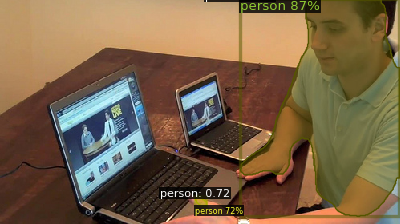

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001459.png

Processing test image 2/3: 000000001380.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001380_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001380_instance.png


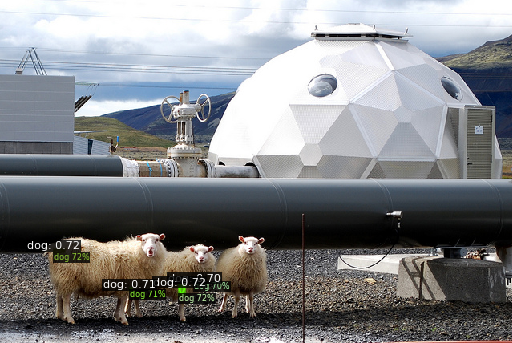

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001380.png

Processing test image 3/3: 000000001551.jpg
Saved semantic mask: /content/drive/MyDrive/deeplabv3_test_output/000000001551_semantic.png
Saved instance mask: /content/drive/MyDrive/deeplabv3_test_output/000000001551_instance.png


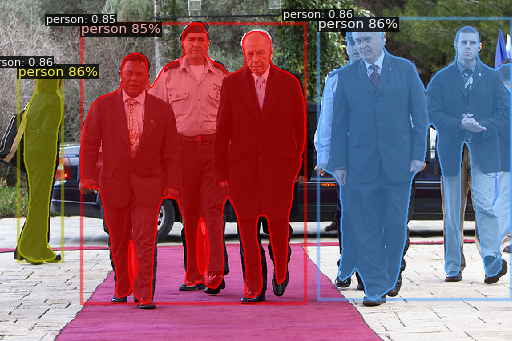

Saved visualization: /content/drive/MyDrive/deeplabv3_test_output/test_result_000000001551.png

Saved 3 predictions to /content/drive/MyDrive/deeplabv3_test_output/panoptic_results.json

Inference on test images complete.

Pipeline complete.


In [ ]:
# Step 6: Test Inference
model.eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if not os.path.exists(TEST_IMAGE_DIR):
    print(f"Test image directory not found at {TEST_IMAGE_DIR}.")
else:
    print(f"\n--- Performing Inference on Test Images from: {TEST_IMAGE_DIR} ---")
    test_image_paths = [f for f in glob(os.path.join(TEST_IMAGE_DIR, '*.*')) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(test_image_paths)
    num_test_visualizations = min(3, len(test_image_paths))

    if num_test_visualizations == 0:
        print("No image files found in the test directory.")
    else:
        dataset_metadata = MetadataCatalog.get("my_coco_train_custom")
        dataset_metadata.thing_classes = class_names
        predictions = []
        confidence_threshold = 0.7

        for i in range(num_test_visualizations):
            img_path = test_image_paths[i]
            im = cv2.imread(img_path)
            if im is None:
                print(f"Could not read image: {img_path}. Skipping.")
                continue

            print(f"\nProcessing test image {i+1}/{num_test_visualizations}: {os.path.basename(img_path)}")
            input_image = Image.open(img_path).convert('RGB')
            input_tensor = preprocess(input_image).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)['out'][0]
            output = torch.softmax(output, dim=0).cpu().numpy()
            output = cv2.resize(output.transpose(1, 2, 0), (im.shape[1], im.shape[0]), interpolation=cv2.INTER_LINEAR)
            output = output.transpose(2, 0, 1)

            semantic_mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
            for idx, (class_name, mapped_id) in enumerate([(category_mapping[cid][0], category_mapping[cid][1]) for cid in target_category_ids], 1):
                class_mask = output[idx] > confidence_threshold
                semantic_mask[class_mask] = mapped_id

            instance_mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint32)
            instance_id = 1
            for idx, mapped_id in enumerate([category_mapping[cid][1] for cid in target_category_ids], 1):
                class_mask = (semantic_mask == mapped_id).astype(np.uint8)
                labeled_mask, num_instances = label(class_mask)
                for inst_id in range(1, num_instances + 1):
                    instance_mask[labeled_mask == inst_id] = instance_id
                    instance_id += 1

            semantic_output_path = os.path.join(TEST_OUTPUT_DIR, os.path.basename(img_path).rsplit('.', 1)[0] + '_semantic.png')
            Image.fromarray(semantic_mask).save(semantic_output_path)
            print(f"Saved semantic mask: {semantic_output_path}")

            instance_output_path = os.path.join(TEST_OUTPUT_DIR, os.path.basename(img_path).rsplit('.', 1)[0] + '_instance.png')
            Image.fromarray(instance_mask).save(instance_output_path)
            print(f"Saved instance mask: {instance_output_path}")

            pred_instances = Instances((im.shape[0], im.shape[1]))
            pred_masks = []
            pred_classes = []
            pred_scores = []
            pred_boxes = []

            for inst_id in range(1, instance_id):
                inst_mask = instance_mask == inst_id
                if inst_mask.sum() == 0:
                    continue
                class_id = semantic_mask[inst_mask][0]
                if class_id == 0:
                    continue
                idx = next(i for i, mapped_id in enumerate([category_mapping[cid][1] for cid in target_category_ids], 1) if mapped_id == class_id)
                y, x = np.where(inst_mask)
                box = [x.min(), y.min(), x.max(), y.max()]
                score = output[idx][inst_mask].mean()
                pred_masks.append(inst_mask)
                pred_classes.append(idx)
                pred_scores.append(score)
                pred_boxes.append(box)

            if pred_masks:
                pred_instances.pred_masks = torch.tensor(np.array(pred_masks), dtype=torch.bool)
                pred_instances.pred_classes = torch.tensor(pred_classes, dtype=torch.int64)
                pred_instances.scores = torch.tensor(pred_scores, dtype=torch.float32)
                pred_instances.pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)

            v = Visualizer(im[:, :, ::-1], metadata=dataset_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
            if len(pred_masks) > 0:
                out = v.draw_instance_predictions(pred_instances)
                for box, score, class_id in zip(pred_boxes, pred_scores, pred_classes):
                    class_name = class_names[class_id]
                    x0, y0, _, _ = box
                    v.draw_text(f"{class_name}: {score:.2f}", (x0, y0 - 10), font_size=10, color="white")
                visualized_img = out.get_image()[:, :, ::-1]
            else:
                visualized_img = im.copy()
            cv2_imshow(visualized_img)

            vis_output_path = os.path.join(TEST_OUTPUT_DIR, f'test_result_{os.path.basename(img_path).rsplit(".", 1)[0]}.png')
            cv2.imwrite(vis_output_path, visualized_img)
            print(f"Saved visualization: {vis_output_path}")

            # Convert pred_scores to native floats for JSON serialization
            scores_as_floats = [float(score) for score in pred_scores]

            predictions.append({
                'image': os.path.basename(img_path),
                'semantic_mask': semantic_mask.tolist(),
                'instance_mask': instance_mask.tolist(),
                'scores': scores_as_floats
            })

        json_output_path = os.path.join(TEST_OUTPUT_DIR, 'panoptic_results.json')
        with open(json_output_path, 'w') as f:
            json.dump(predictions, f)
        print(f"\nSaved {len(predictions)} predictions to {json_output_path}")

        print("\nInference on test images complete.")

print("\nPipeline complete.")
